# Фреймворк PyTorch для разработки искусственных нейронных сетей
## Урок 2. Feed-forward neural network

### <b>Практическое задание:</b> <br>
<ol>
<li>Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing) </li>
<li> Обернуть его в Dataloader </li>
<li> Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать) </li>
<li> Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели </li>
</ol>
train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25


## 1. Загрузка библиотек

In [5]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torch import optim

## 2. Загрузка данных

In [6]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target[..., np.newaxis], test_size=0.25, random_state=13)

In [7]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## 3.  EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Пропусков нет, что уже хорошо

In [9]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


## 4.  Создаем Dataset для загрузки данных

In [10]:
class HouseDataset(torch.utils.data.Dataset):
  
  X_scaler = None
  y_scaler = None

  def __init__(self, data, labels, train=True):
    self.data, self.labels = self.scaler(data, labels, train)

  @classmethod
  def scaler(cls, data, labels, train=True):
    if train:
      cls.X_scaler = StandardScaler()
      cls.X_scaler.fit(data)
      cls.y_scaler = StandardScaler()
      cls.y_scaler.fit(labels)      
      labels = cls.y_scaler.transform(labels)        

    return cls.X_scaler.transform(data), labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [11]:
train_dataset = HouseDataset(X_train, y_train, train=True)
test_dataset = HouseDataset(X_test, y_test, train=False)
train_dataset[0]

(array([-0.18148348,  0.57913684, -0.34002073, -0.00446324, -0.06538333,
        -0.08711252, -0.67176218,  0.67560682]), array([0.53292426]))

## 5. Обернуть его в Dataloader

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader =  torch.utils.data.DataLoader(test_dataset,
                                           batch_size=8,
                                           shuffle=False)

## 6. Напишем архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

In [15]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, deep, dropout):
        super().__init__()
        self.fc = nn.ModuleList()
        self.bn = nn.ModuleList()

        self.fc.append(nn.Linear(input_dim, 2**(deep - 2) * hidden_dim))
        self.bn.append(nn.BatchNorm1d(2**(deep - 2) * hidden_dim))
        for i in range(1, deep - 1):
          self.fc.append(nn.Linear(2**(deep - 1 - i) * hidden_dim, 2**(deep - 2 - i) * hidden_dim))
          self.bn.append(nn.BatchNorm1d(2**(deep - 2 - i) * hidden_dim))
        self.fc.append(nn.Linear(hidden_dim, output_dim))

        self.dp = nn.Dropout(dropout)

    def forward(self, x):

        for i in range(len(self.bn)):
          x = self.fc[i](x)
          x = self.bn[i](x)
          x = torch.tanh(x)
          x = self.dp(x)

        x = self.fc[len(self.bn)](x)
        return x

In [16]:
def net_train(train_loader, test_loader, num_epochs, hidden_dim, deep, dropout, optimiz, lr, noise):
  net = Net(8, 1, hidden_dim, deep, dropout).double()
  net.train()

  criterion = nn.MSELoss()

  if optimiz == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=lr)

  if optimiz == 'rmsprop':
    optimizer = optim.RMSprop(net.parameters(), lr=lr)

  if optimiz == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=lr)

  train_loss_list = []

  for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0
    test_mse = 0.0

    for data in train_loader:

      inputs, labels = data[0], data[1]
      # Обнуляем градиент
      optimizer.zero_grad()
      # Делаем предсказание
      outputs = net(inputs)
      # Рассчитываем лосс-функцию
      loss = criterion(outputs, labels)
      # Делаем шаг назад по лоссу
      loss.backward()
      # Делаем шаг нашего оптимайзера
      optimizer.step()
      train_loss += loss.item()

    # Расчитываем loss на test
    for data in test_loader:
      inputs, labels = data[0], data[1]
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      test_loss += loss.item()

    # Расчитываем mse на test
      with torch.no_grad():
        outputs = HouseDataset.y_scaler.inverse_transform(outputs)
      outputs = torch.from_numpy(outputs)

      loss = criterion(outputs, labels)
      test_mse += loss.item()

    # выводим статистику о процессе обучения
    if noise:
      print(f'Epoch: {epoch + 1}; '\
            f'Train_loss: {round(train_loss / len(train_loader), 3)}; '\
            f'Test_loss: {round(test_loss / len(test_loader), 3)}; '\
            f'Test_MSE: {round(test_mse / len(test_loader), 3)}')
    
    train_loss_list.append(train_loss / len(train_loader))
  
  return net, round(test_mse / len(test_loader), 3), train_loss_list

In [17]:
%%time

net = net_train(train_loader, test_loader, num_epochs=10, hidden_dim=40, 
                deep=4, dropout=0.1, optimiz='adam', lr=0.01, noise=True)[0]

Epoch: 1; Train_loss: 0.399; Test_loss: 4.918; Test_MSE: 0.617
Epoch: 2; Train_loss: 0.312; Test_loss: 4.743; Test_MSE: 0.598
Epoch: 3; Train_loss: 0.296; Test_loss: 4.676; Test_MSE: 0.598
Epoch: 4; Train_loss: 0.284; Test_loss: 4.771; Test_MSE: 0.569
Epoch: 5; Train_loss: 0.278; Test_loss: 5.01; Test_MSE: 0.595
Epoch: 6; Train_loss: 0.274; Test_loss: 4.791; Test_MSE: 0.572
Epoch: 7; Train_loss: 0.265; Test_loss: 4.748; Test_MSE: 0.571
Epoch: 8; Train_loss: 0.27; Test_loss: 4.654; Test_MSE: 0.575
Epoch: 9; Train_loss: 0.256; Test_loss: 4.85; Test_MSE: 0.593
Epoch: 10; Train_loss: 0.255; Test_loss: 4.583; Test_MSE: 0.59
CPU times: user 11.8 s, sys: 1.21 s, total: 13 s
Wall time: 17.2 s


### hidden_dim

In [18]:
%%time

hidden_dim_list = [10, 20, 30, 40, 50, 75, 100]

for hidden_dim in hidden_dim_list:
  print(hidden_dim, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=hidden_dim, 
                                  deep=4, dropout=0.1, optimiz='adam', lr=0.01, noise=False)[1])

10 - 0.615
20 - 0.597
30 - 0.598
40 - 0.581
50 - 0.565
75 - 0.586
100 - 0.579
CPU times: user 1min 25s, sys: 4.63 s, total: 1min 30s
Wall time: 1min 53s


### deep


In [19]:
%%time

deep_list = [2, 3, 4, 5, 6]

for deep in deep_list:
  print(deep, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=50, 
                                  deep=deep, dropout=0.1, optimiz='adam', lr=0.01, noise=False)[1])

2 - 0.584
3 - 0.581
4 - 0.564
5 - 0.636
6 - 0.603
CPU times: user 1min 22s, sys: 3.59 s, total: 1min 26s
Wall time: 1min 39s


### dropout

In [20]:
%%time

dropout_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

for dropout in dropout_list:
  print(dropout, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=50, 
                                  deep=3, dropout=dropout, optimiz='adam', lr=0.01, noise=False)[1])

0.0 - 0.54
0.1 - 0.54
0.2 - 0.59
0.3 - 0.61
0.4 - 0.594
0.5 - 0.646
CPU times: user 53.4 s, sys: 3.94 s, total: 57.4 s
Wall time: 1min 8s


### optimiz

In [21]:
%%time

optimiz_list = ['adam', 'rmsprop', 'sgd']

for optimiz in optimiz_list:
  print(optimiz, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=50, 
                                  deep=3, dropout=0.0, optimiz=optimiz, lr=0.01, noise=False)[1])

adam - 0.56
rmsprop - 0.546
sgd - 0.592
CPU times: user 24.9 s, sys: 1.93 s, total: 26.8 s
Wall time: 32.1 s


### lr

In [31]:
%%time

lr_list = [0.0001, 0.001, 0.01, 0.1, 1]

for lr in lr_list:
  print(lr, '-', net_train(train_loader, test_loader, num_epochs=10, hidden_dim=50, 
                                  deep=3, dropout=0.0, optimiz='adam', lr=lr, noise=False)[1])

0.0001 - 0.593
0.001 - 0.547
0.01 - 0.536
0.1 - 0.597
1 - 0.805
CPU times: user 40 s, sys: 3.23 s, total: 43.2 s
Wall time: 48.7 s


0.0001 - 0.599
0.001 - 0.557
0.01 - 0.533
0.1 - 0.576
1 - 2.358
CPU times: user 43.5 s, sys: 3.23 s, total: 46.8 s
Wall time: 55.8 s

### Лучшая модель

In [23]:
%%time

net = net_train(train_loader, test_loader, num_epochs=20, hidden_dim=50, 
              deep=3, dropout=0.0, optimiz='adam', lr=0.01, noise=True)[0]

Epoch: 1; Train_loss: 0.371; Test_loss: 4.923; Test_MSE: 0.598
Epoch: 2; Train_loss: 0.299; Test_loss: 5.014; Test_MSE: 0.563
Epoch: 3; Train_loss: 0.274; Test_loss: 5.057; Test_MSE: 0.566
Epoch: 4; Train_loss: 0.274; Test_loss: 4.754; Test_MSE: 0.555
Epoch: 5; Train_loss: 0.259; Test_loss: 4.889; Test_MSE: 0.546
Epoch: 6; Train_loss: 0.254; Test_loss: 5.043; Test_MSE: 0.54
Epoch: 7; Train_loss: 0.254; Test_loss: 5.099; Test_MSE: 0.548
Epoch: 8; Train_loss: 0.24; Test_loss: 4.81; Test_MSE: 0.555
Epoch: 9; Train_loss: 0.242; Test_loss: 5.204; Test_MSE: 0.556
Epoch: 10; Train_loss: 0.233; Test_loss: 5.028; Test_MSE: 0.535
Epoch: 11; Train_loss: 0.235; Test_loss: 4.944; Test_MSE: 0.55
Epoch: 12; Train_loss: 0.233; Test_loss: 5.08; Test_MSE: 0.579
Epoch: 13; Train_loss: 0.23; Test_loss: 4.616; Test_MSE: 0.547
Epoch: 14; Train_loss: 0.235; Test_loss: 4.755; Test_MSE: 0.527
Epoch: 15; Train_loss: 0.223; Test_loss: 4.861; Test_MSE: 0.534
Epoch: 16; Train_loss: 0.223; Test_loss: 4.844; Test_MS

## 7. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

In [24]:
%%time

adam_mse = net_train(train_loader, test_loader, num_epochs=20, hidden_dim=50, 
              deep=3, dropout=0.0, optimiz='adam', lr=0.01, noise=False)[2]

CPU times: user 16.1 s, sys: 1.26 s, total: 17.4 s
Wall time: 19.2 s


In [25]:
%%time

rmsprop_mse = net_train(train_loader, test_loader, num_epochs=20, hidden_dim=50, 
              deep=3, dropout=0.0, optimiz='rmsprop', lr=0.01, noise=False)[2]

CPU times: user 16.8 s, sys: 1.28 s, total: 18.1 s
Wall time: 24.1 s


In [26]:
%%time

sgd_mse = net_train(train_loader, test_loader, num_epochs=20, hidden_dim=50, 
              deep=3, dropout=0.0, optimiz='sgd', lr=0.01, noise=False)[2]

CPU times: user 16 s, sys: 1.24 s, total: 17.2 s
Wall time: 20.5 s


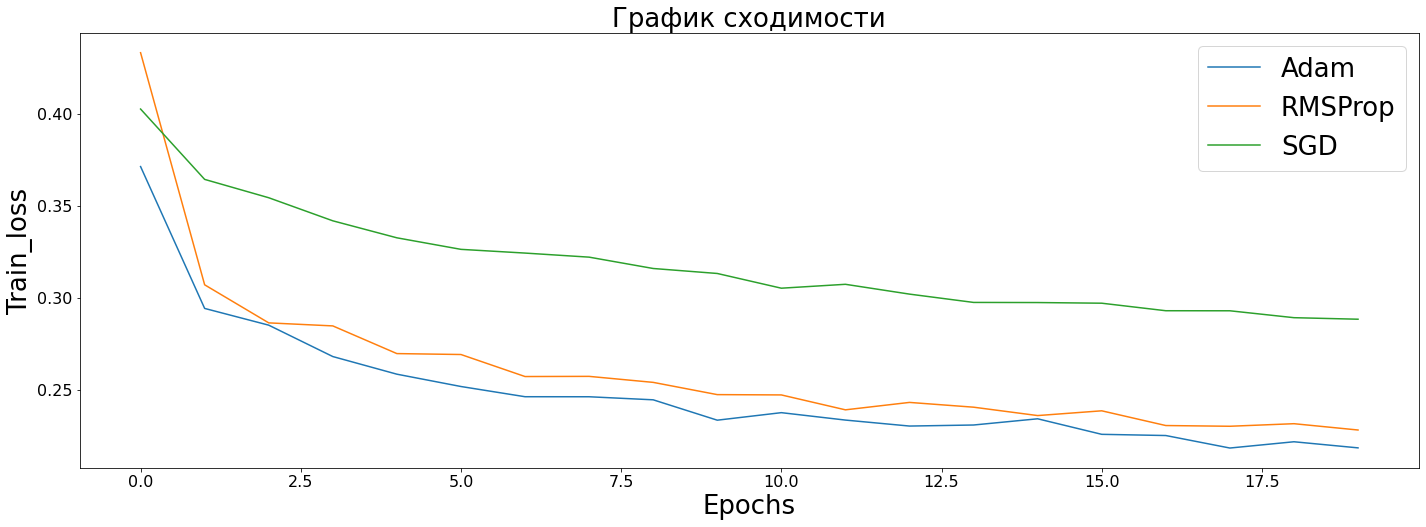

In [27]:
fontsize = 26

plt.figure(figsize=(24, 8))
plt.title('График сходимости', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.ylabel('Train_loss', fontsize=fontsize)
plt.plot(adam_mse, label='Adam')
plt.plot(rmsprop_mse, label='RMSProp')
plt.plot(sgd_mse, label='SGD')
plt.legend(fontsize=fontsize)
plt.tick_params(labelsize=16)
plt.show()

**Вывод** <br>
Мною был создан Dataset из данных sklearn.datasets.fetch_california_housing, обернут в Dataloader. <br>
Написана архитектура сети, состоящей из 50 скрытых слоёв и включающая в себя BatchNorm и Dropout. <br>
С помощью перебора были найдены лучшие параметры для сети, такие как количество скрытых слоёв (hidden_dim), глубина (deep), dropout, скорость обучения (learning_rate). Количество эпох взял 20. <br>
Было вроведено сравнение разных оптимизаторов. Лучше всех себя показал Adam.